## **[Machine Learning for Forecasting: Supervised Learning with Multivariate Time Series](https://towardsdatascience.com/machine-learning-for-forecasting-supervised-learning-with-multivariate-time-series-b5b5044fe068)**
#### **An Introduction to the Auto-regressive Distributed Lags Model using Python.**

Here, you’ll learn how to create forecasting models with multivariate time series.

In [81]:
import sys
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

,Fortified,Drywhite,Sweetwhite,Red,Rose,Sparkling,date
0,2585,1954,85,464,112.0,1686,1980-01-01
1,3368,2302,89,675,118.0,1591,1980-02-01
2,3210,3054,109,703,129.0,2304,1980-03-01
3,3111,2414,95,887,99.0,1712,1980-04-01
4,3756,2226,91,1139,116.0,1471,1980-05-01
...,...,...,...,...,...,...,...
182,1818,4067,188,2459,45.0,1897,1995-03-01
183,2262,4022,195,2618,52.0,1862,1995-04-01
184,2612,3937,189,2585,28.0,1670,1995-05-01
185,2967,4365,220,3310,40.0,1688,1995-06-01


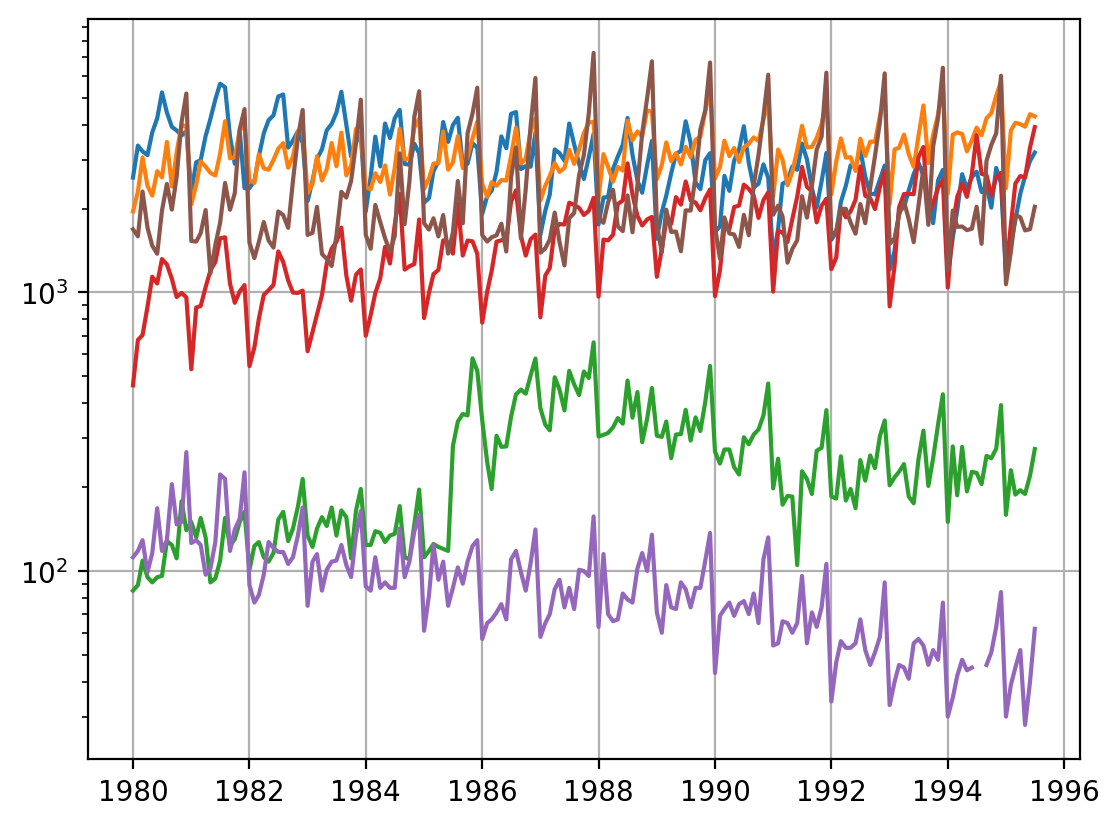

In [82]:
from src.tde import time_delay_embedding

wine = pd.read_csv('../data/wine_sales.csv', parse_dates=['date'])
display(wine)

fig, ax = plt.subplots(dpi = 200)
ax.plot(wine['date'], wine[wine.columns[:-1]])
ax.set_yscale('log')
ax.grid()
plt.show()

#### Introduction**
A time series is multivariate if it contains more than one variable.

See Figure 1 for an example. It shows a monthly multivariate time series about the sales of different types of wine. Each wine type is a variable in the time series.

Suppose you want to forecast one of the variables. Say, the sales of sparkling wine (personal favourite :-) ). How can you build a model to do that?

A common approach is to take that variable and view it as a univariate time series. There are plenty of methods designed to model these series. Examples include ARIMA, exponential smoothing, or Facebook’s Prophet. Auto-regressive machine learning approaches are increasingly used.

Yet, other variables may contain important clues about future sales of sparkling wine. Take a look at the correlation matrix below.

<Axes: >

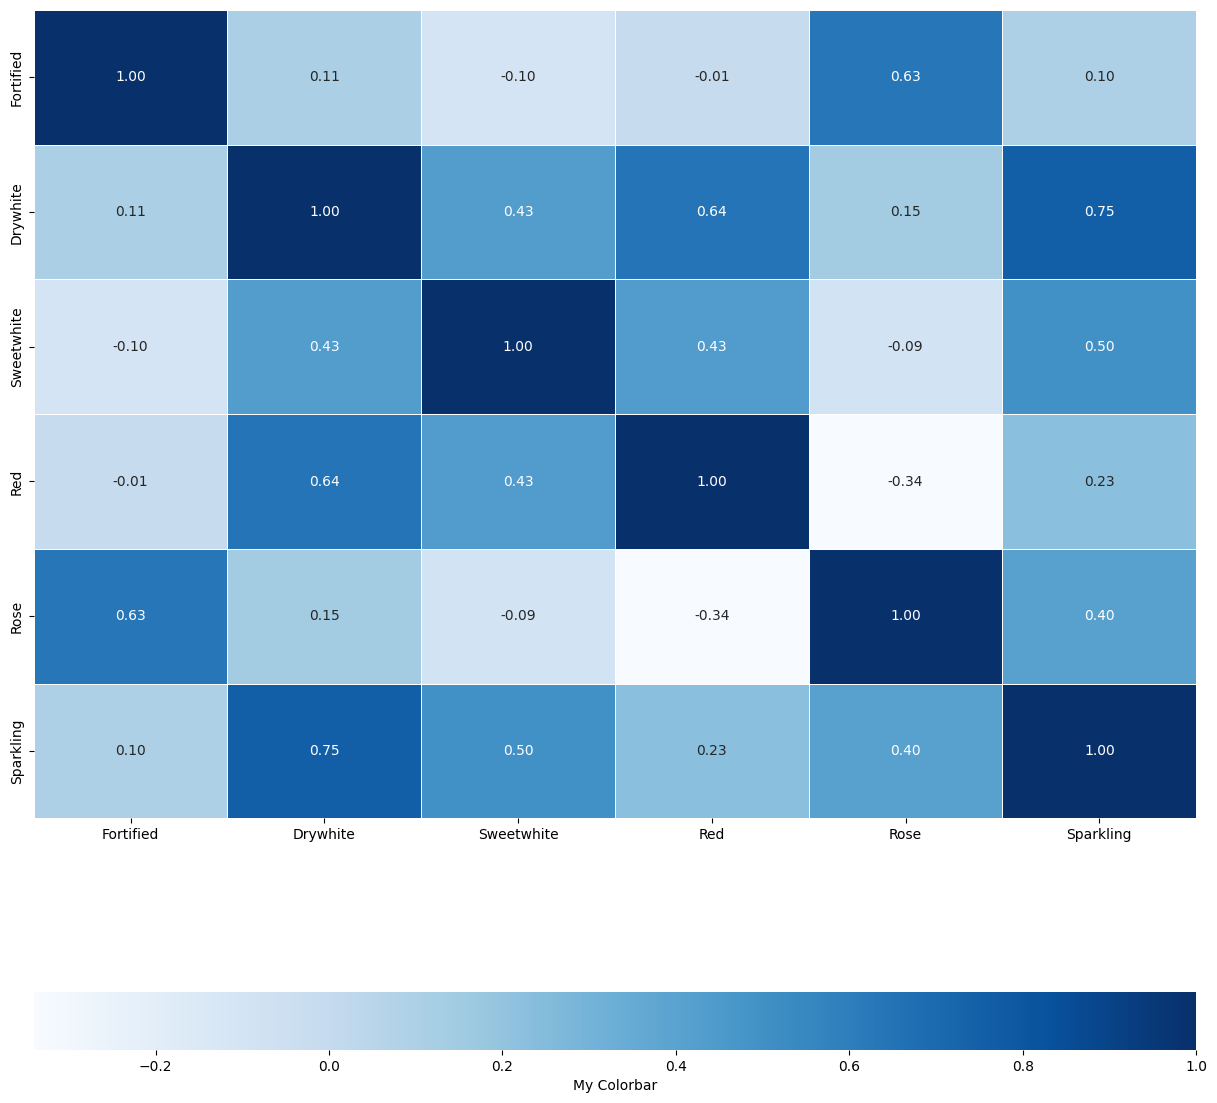

In [83]:
plt.figure(figsize=(15,15))
sns.heatmap(data = wine[wine.columns[:-1]].corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues',
            cbar_kws={'label': 'My Colorbar', 'orientation': 'horizontal'})

The sales of sparkling wine (second row) show a decent correlation with the sales of other wines.

So, it might be a good idea to try and include these variables in the model.

We can do this with an approach called **Auto-Regressive Distributed Lag (ARDL).**

#### **Auto-Regressive Distributed Lag**

#### **Auto-regression with univariate time series**
As the name implies, the ARDL model settles on auto-regression.

Auto-regression is the backbone of most univariate time series models. It works in two main steps.

First, we transform the (univariate) time series from a sequence of values to a matrix. We do this with the method time delay embedding. Despite the fancy name, this approach is quite simple. The idea is to model each value based on the past recent values before it.

Then, we build a regression model. The future values represent the target variable. The explanatory variables are the past recent values.

#### **The multivariate case**
The idea is similar for multivariate time series. But, you also add the past values of other variables to the explanatory variables. This leads to the method called **Auto-Regressive Distributed Lags**. The Distributed Lags name refers to the use of the lags of extra variables.

Putting it all together. The future values of a variable in a time series depend on its own lags and the lags of other variables.

Let’s code this method to make it clear.

#### **Hands On**
Multivariate time series often refer to sales data of many related products. We’ll use the wine sales time series as example. Yet, the ARDL approach is also applicable to other domains besides retail.

#### **Transforming the Time Series**
We start by transforming the time series using the script below.

In [84]:
import pandas as pd

from src.tde import time_delay_embedding

wine = pd.read_csv('../data/wine_sales.csv', parse_dates=['date'])

# setting date as index
wine.set_index('date', inplace=True)

# you can simulate some data with the following code
# wine = pd.DataFrame(np.random.random((100, 6)),
#            columns=['Fortified','Drywhite','Sweetwhite',
#                      'Red','Rose','Sparkling'])

# create data set with lagged features using time delay embedding
wine_ds = []
for col in wine:
    col_df = time_delay_embedding(wine[col], n_lags=12, horizon=6)
    wine_ds.append(col_df)

# concatenating all variables
wine_df = pd.concat(wine_ds, axis=1).dropna()

# defining target (Y) and explanatory variables (X)
predictor_variables = wine_df.columns.str.contains('\(t\-')
target_variables = wine_df.columns.str.contains('Sparkling\(t\+')

X = wine_df.iloc[:, predictor_variables]
Y = wine_df.iloc[:, target_variables]

We apply the function time_delay_embedding to each variable in the time series (lines 17–19). The results are concatenated into a single pandas data frame in line 22.

The explanatory variables ($X$) are the last 12 known values of each variable at each time step (line 28). Here’s how these look for the lag t-1 (other lags omitted for conciseness):

In [85]:
X.head(5)

,Fortified(t-11),Fortified(t-10),Fortified(t-9),Fortified(t-8),Fortified(t-7),Fortified(t-6),Fortified(t-5),Fortified(t-4),Fortified(t-3),Fortified(t-2),...,Sparkling(t-10),Sparkling(t-9),Sparkling(t-8),Sparkling(t-7),Sparkling(t-6),Sparkling(t-5),Sparkling(t-4),Sparkling(t-3),Sparkling(t-2),Sparkling(t-1)
date,,,,,,,,,,,,,,,,,,,,,
1981-01-01,2585.0,3368.0,3210.0,3111.0,3756.0,4216.0,5225.0,4426.0,3932.0,3816.0,...,1591.0,2304.0,1712.0,1471.0,1377.0,1966.0,2453.0,1984.0,2596.0,4087.0
1981-02-01,3368.0,3210.0,3111.0,3756.0,4216.0,5225.0,4426.0,3932.0,3816.0,3661.0,...,2304.0,1712.0,1471.0,1377.0,1966.0,2453.0,1984.0,2596.0,4087.0,5179.0
1981-03-01,3210.0,3111.0,3756.0,4216.0,5225.0,4426.0,3932.0,3816.0,3661.0,3795.0,...,1712.0,1471.0,1377.0,1966.0,2453.0,1984.0,2596.0,4087.0,5179.0,1530.0
1981-04-01,3111.0,3756.0,4216.0,5225.0,4426.0,3932.0,3816.0,3661.0,3795.0,2285.0,...,1471.0,1377.0,1966.0,2453.0,1984.0,2596.0,4087.0,5179.0,1530.0,1523.0
1981-05-01,3756.0,4216.0,5225.0,4426.0,3932.0,3816.0,3661.0,3795.0,2285.0,2934.0,...,1377.0,1966.0,2453.0,1984.0,2596.0,4087.0,5179.0,1530.0,1523.0,1633.0


The target variables are defined in line 29. These refer to the future 6 values of sparkling wine sales:

In [86]:
Y.head()

,Sparkling(t+1),Sparkling(t+2),Sparkling(t+3),Sparkling(t+4),Sparkling(t+5),Sparkling(t+6)
date,,,,,,
1981-01-01,1530,1523.0,1633.0,1976.0,1170.0,1480.0
1981-02-01,1523,1633.0,1976.0,1170.0,1480.0,1781.0
1981-03-01,1633,1976.0,1170.0,1480.0,1781.0,2472.0
1981-04-01,1976,1170.0,1480.0,1781.0,2472.0,1981.0
1981-05-01,1170,1480.0,1781.0,2472.0,1981.0,2273.0


#### **Building a Model**
After preparing the data, you’re ready to build a model. Below, I apply a simple training and testing cycle using a Random Forest.

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor


# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state = 1234)

# fitting a RF model
model = RandomForestRegressor(random_state = 1234)
model.fit(X_tr, Y_tr)

# getting forecasts for the test set
preds = model.predict(X_ts)

# computing MAE error
print(mae(Y_ts, preds))
# 288.13

311.3823958333333


After fitting the model (line 11), we get the predictions in the test set (line 14). The model gets a mean absolute error of 311.382.

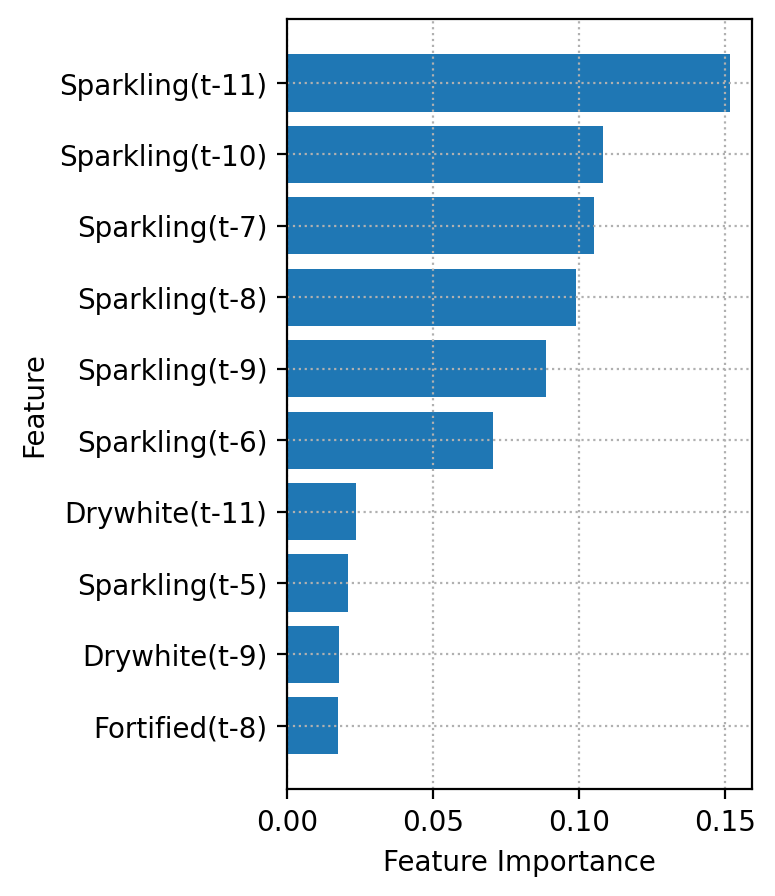

In [88]:
fig, ax = plt.subplots(figsize = (3, 5), dpi = 200)

# getting top 10 features
importance_scores = pd.Series(dict(zip(X_tr.columns, model.feature_importances_)))
top_10_features = importance_scores.sort_values(ascending=False)[:10]
top_10_features_nm = top_10_features.index

ax.barh(top_10_features_nm, top_10_features)
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
ax.grid(linestyle = ':')
ax.invert_yaxis()
plt.show()

#### **Choosing the Number of Lags**

We used 12 lags of each variable as explanatory variables. This was defined in the parameter n_lags of the function time_delay_embedding.
**_How should you set the value of this parameter?_**

It’s difficult to say apriori how many values should be included. That depends on the input data and the specific variable.

A simple way to approach this is to use feature selection. **_First, start with a fair amount of values. Then reduce this number according to importance scores or forecasting performance._**

Here’s a simplified version of this process. The top 10 features are selected according to the Random Forests’ importance scores. Then, the training and testing cycle is repeated.


In [89]:
# getting importance scores from previous model
importance_scores = pd.Series(dict(zip(X_tr.columns, model.feature_importances_)))

# getting top 10 features
top_10_features = importance_scores.sort_values(ascending=False)[:10]
top_10_features_nm = top_10_features.index

X_tr_top = X_tr[top_10_features_nm]
X_ts_top = X_ts[top_10_features_nm]

# re-fitting the model
model_top_features = RandomForestRegressor()
model_top_features.fit(X_tr_top, Y_tr)

# getting forecasts for the test set
preds_topf = model_top_features.predict(X_ts_top)

# computing MAE error
print(mae(Y_ts, preds_topf))
# 274.36

262.4596180555556


As expected, the lags of the target variable (Sparkling) are the most important. But, some lags of other variables are also relevant.

### **Extensions to ARDL**
#### **Multiple Target Variables**
We aimed at forecasting a single variable (sparkling wine). What if we are interested in forecasting several ones?

This would lead to a method called Vector Auto-Regressive (VAR).

Like in ARDL, each variable is modelled based on its lags and the lags of other variables. VAR is used when you want to predict many variables, not just one.

#### **Relation to Global Forecasting Models**
It’s worth noting that ARDL is not the same as a Global Forecasting Model.

In the case of ARDL, the information of each variable is added in the explanatory variables. The number of variables is usually low and of the same size.

Global forecasting models pool the historical observations of many time series. A model is fit with these observations. So, each new series is added as new observations. Besides, global forecasting models usually involve up to thousands of time series. In a previous post, I describe how Global Forecasting Models operate. These are increasingly used approaches for forecasting.

### **Take-Aways**
- A multivariate time series is contains two or more variables;
- The ARDL method can be used for supervised learning with multivariate time series;
- Optimize the number of lags using feature selection strategies.
- Use a VAR method if you want to predict more than one variable.

Thanks for reading, and see you in the next story!